<a href="https://colab.research.google.com/github/leehj2586/leehj/blob/ESAA_OB/ESAA_1125_%ED%8C%8C%EB%94%A5%ED%85%904%EC%9E%A5_%ED%95%A9%EC%84%B1%EA%B3%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파이썬 딥러닝 텐서플로 ch4. 7 pg. 229~240

## 07. 이미지 분할 Image Segmentation
- 이미지를 구성하는 모든 픽셀에 대해 픽셀 단위로 분류
- 모든 픽셀은 어떤 클래스에 속함 ex) 배경 or rorcp
- 정답이 레이블된 데이터 가지고 모델 훈련 -> 새로운 이미지에서 배경과 객체 분리 가능
1. 의미 분할: 같은 범주의 여러 객체를 하나의 범주로 묶어서 구분
2. 인스턴스 분할 : 같은 범주에 속하더라도 서로 다른 객체 구분

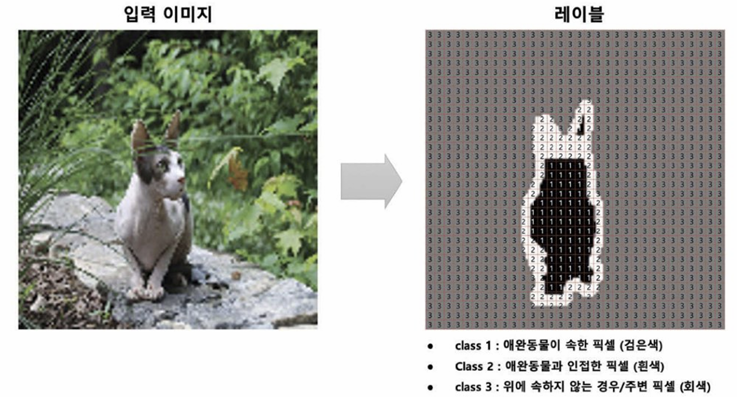

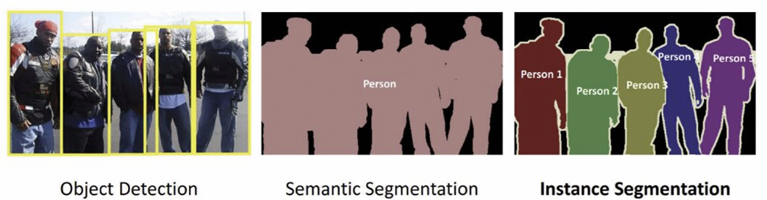

### 7-1. 데이터셋 준비
- Oxford-IIIT Pet Dataset: 반려동물 이미지 및 분류 레이블, 픽셀 단위 마스크(=범주 레이블)


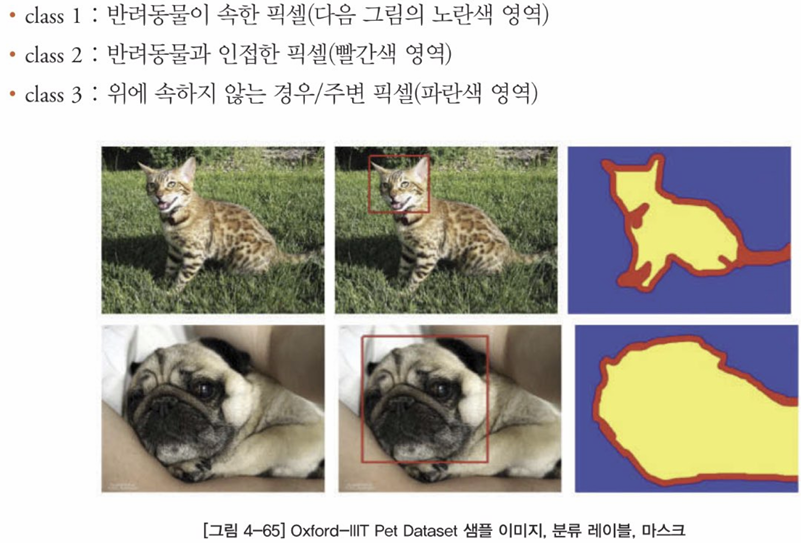

In [1]:
!pip install tensorflow_datasets==4.9.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 32.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_datasets
    Found existing installation: tensorflow-datasets 4.9.7
    Uninstalling tensorflow-datasets-4.9.7:
      Successfully uninstalled tensorflow-datasets-4.9.7


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

모델 학습에 필요한 입력 이미지의 크기와 학습 파라미터 설정

In [3]:
# 이미지 크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w, img_h, img_c)

# 모델 학습
epoch_num = 5
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

In [ ]:
# 텐서플로 데이터셋 로드
ds_str = 'oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [8]:
# 이미지 전처리 함수
def preprocess_image(ds):
    # 원본 이미지
    img = tf.image.resize(ds['image'], (img_w, img_h))
    # 정규화
    img = tf.cast(img, tf.float32) / 255.0
    # 분할 마스크
    mask = tf.image.resize(ds['segmentation_mask'],(img_w, img_h))
    # 자료형 변환
    mask = tf.cast(mask, tf.int32)
    # 마스크: 0, 1, 2 값 같도록 1차감
    mask = mask-1
    return img, mask

In [9]:
# 데이터 전처리 파이프라인
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


In [10]:
# 샘플 배치 선택
img, mask = next(iter(train_ds))
len(img)

16

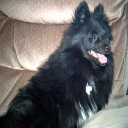

In [11]:
# 샘플 이미지 출력
img = np.array(img[0]) * 255.0
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

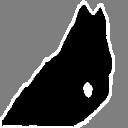

In [12]:
# 샘플 마스크 출력
mask = (np.array(mask[0])/2)*255.0
cv2_imshow(mask)

### 7-2. U-Net 모델(인코더-디코더)
- VGG 16 모델 활용: 합성곱 층과 풀링 층을 직렬로 연결한 구조

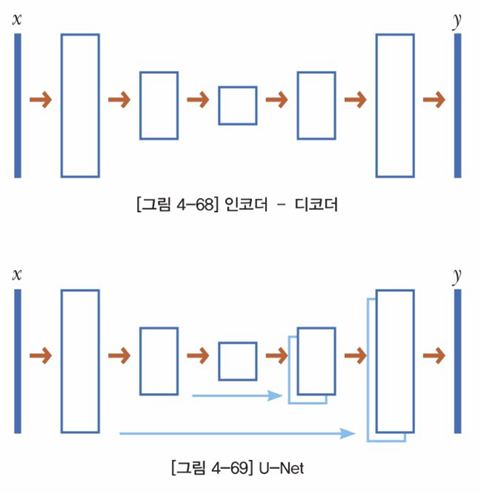

In [14]:
# VGG16 모델
base_model = tf.keras.applications.VGG16(input_shape = img_shape, include_top = False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


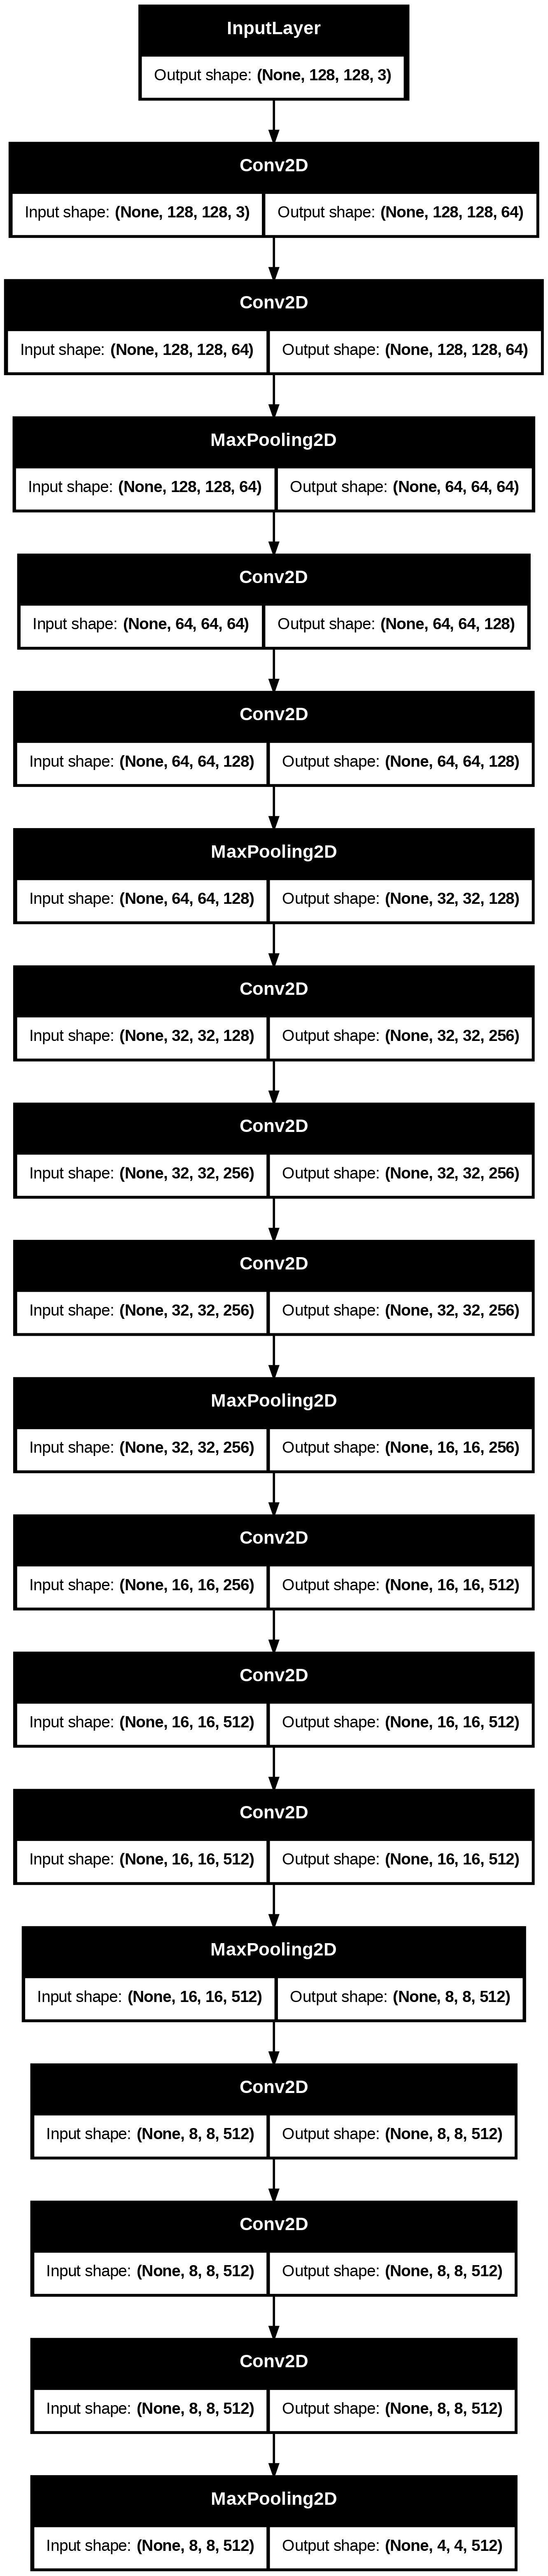

In [15]:
# 모델 구조
tf.keras.utils.plot_model(base_model, show_shapes = True)

- 만들고자하는 U-net의 모양, 사전 학습된 모델에서 어느 부분의 어떤 shape의 출력을 가져올지 결정

In [18]:
# VGG16 중간 레이어 출력 텐서를 지정
f_model = tf.keras.Model(inputs = [base_model.input],
                         outputs = [
                             base_model.get_layer(name = 'block5_conv3').output,
                             base_model.get_layer(name = 'block4_conv3').output,
                             base_model.get_layer(name = 'block3_conv3').output,
                             base_model.get_layer(name = 'block2_conv2').output,
                             base_model.get_layer(name = 'block1_conv1').output
                         ])

In [19]:
# 파라미터 고정
f_model.trainable = False

업샘플링

In [20]:
# U-Net 구조로 모델 정의

i = tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out, out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_128_128_64])

out = tf.keras.layers.Conv2D(3,3,activation='elu',padding='same')(out)
out = tf.keras.layers.Dense(3, activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

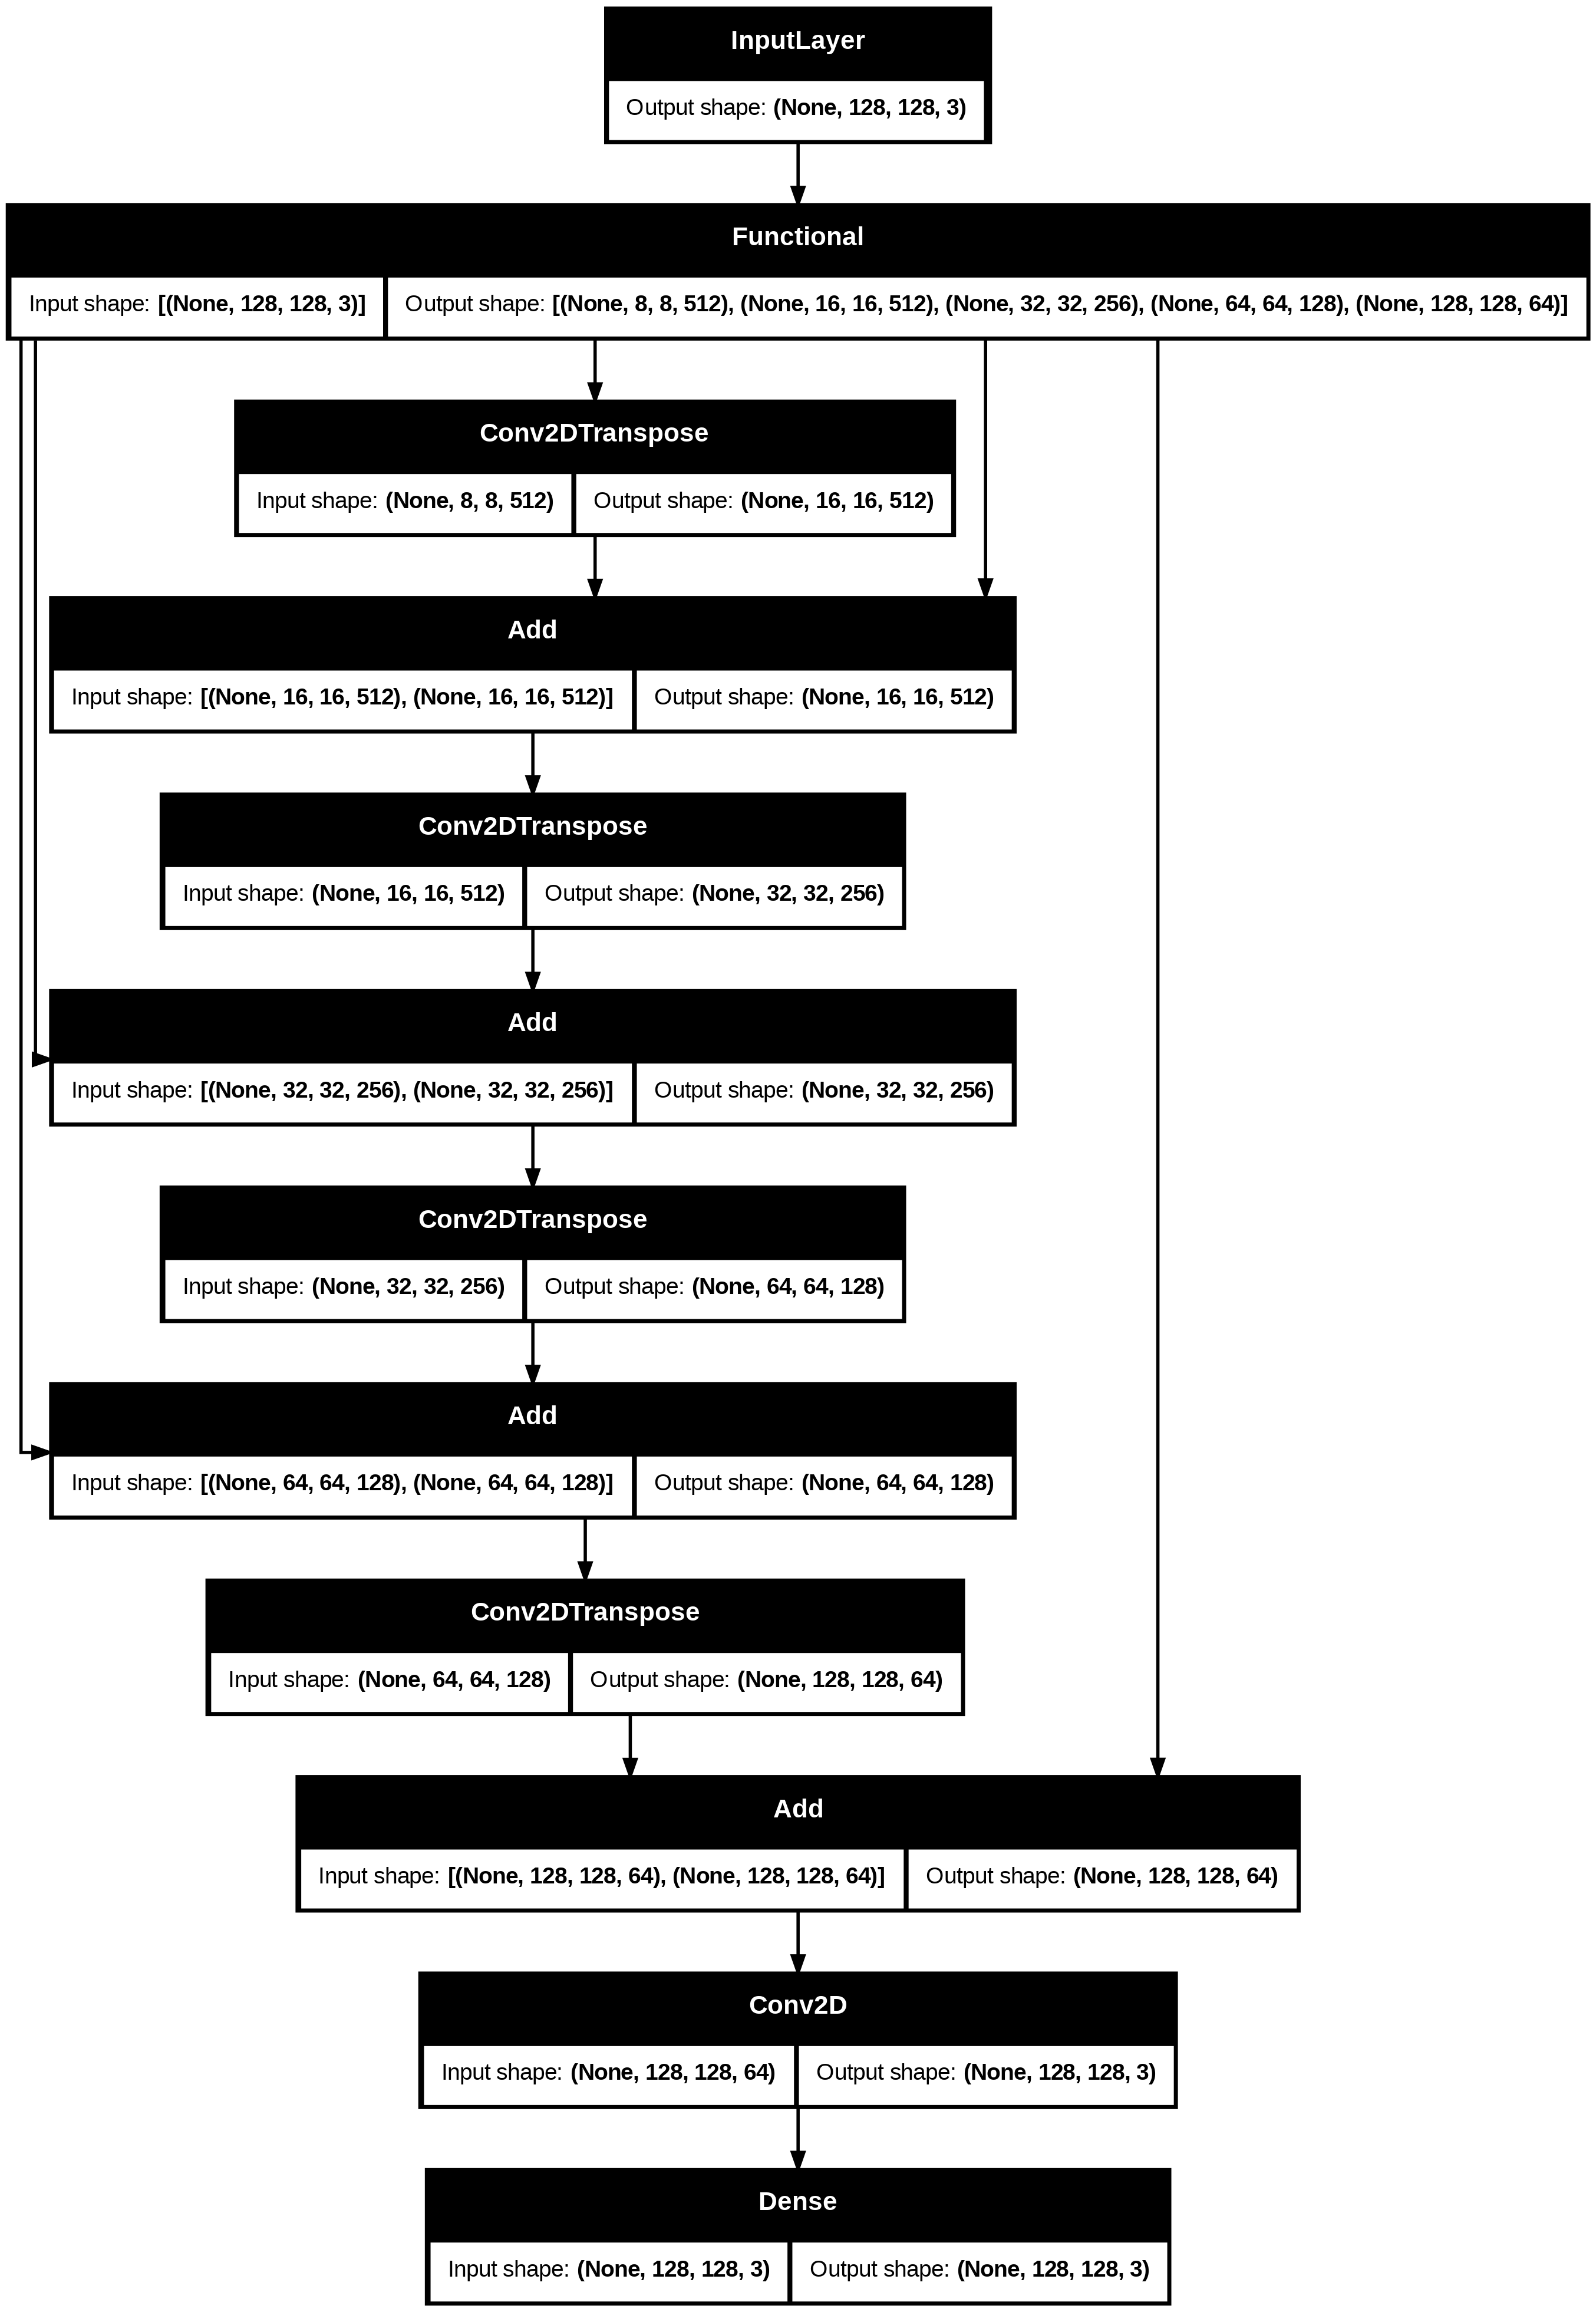

In [21]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [22]:
# 모델 요약
unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ [(None, 8, 8, 512),    │     14,714,688 │ input_layer_1[0][0]    │
│                           │ (None, 16, 16, 512),   │                │                        │
│                           │ (None, 32, 32, 256),   │                │                        │
│                           │ (None, 64, 64, 128),   │                │                        │
│                           │ (None, 128, 128, 64)]  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 512)    │      2,359,808 │ functional[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 16, 16, 512)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ functional[0][1]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 32, 32, 256)    │      1,179,904 │ add[0][0]              │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 32, 32, 256)    │              0 │ conv2d_transpose_1[0]… │
│                           │                        │                │ functional[0][2]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 64, 64, 128)    │        295,040 │ add_1[0][0]            │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 64, 64, 128)    │              0 │ conv2d_transpose_2[0]… │
│                           │                        │                │ functional[0][3]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 128, 128, 64)   │         73,792 │ add_2[0][0]            │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 128, 128, 64)   │              0 │ conv2d_transpose_3[0]… │
│                           │                        │                │ functional[0][4]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 3)    │          1,731 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128, 128, 3)    │             12 │ conv2d[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 18,624,975 (71.05 MB)

 Trainable params: 3,910,287 (14.92 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 1317s 6s/step - accuracy: 0.6098 - loss: 1.1242
Epoch 2/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 1300s 6s/step - accuracy: 0.7772 - loss: 0.5289
Epoch 3/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 1315s 6s/step - accuracy: 0.8033 - loss: 0.4653
Epoch 4/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 1288s 6s/step - accuracy: 0.8131 - loss: 0.4428
Epoch 5/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 1334s 6s/step - accuracy: 0.8256 - loss: 0.4227


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


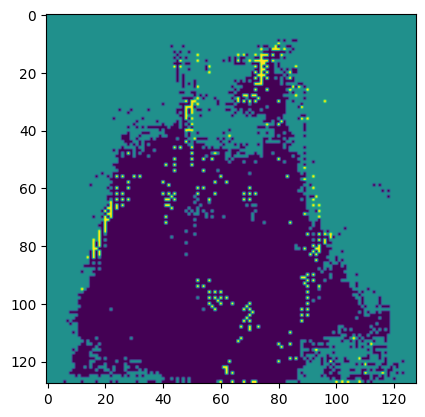

In [24]:
# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫번째 이미지 분할 결과를 출력
pred_img = np.argmax(pred[0], -1)
plt.imshow(pred_img)

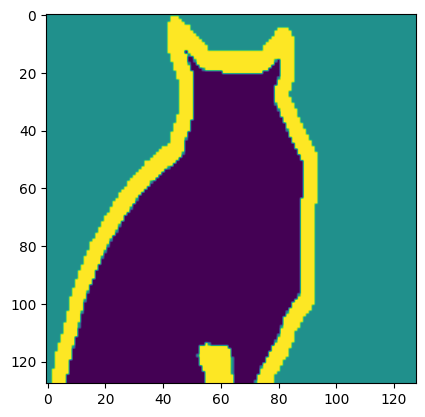

In [25]:
# 첫번째 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0],(128,128)))